In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Load vtk image data file (.vti). 
Compute error with reference file.
"""

import sys
import os
import glob 
import numpy as np
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib
import matplotlib.pyplot as plt

In [2]:
RootDir = sys.argv[1]


In [15]:
#RootDir = '/home/pgrete/src/ppkMHD/test/convergence/test'

In [17]:
L1results = {}

for Filename in glob.glob(RootDir + '/*/*/wave.out'):
    Wavetype = int(Filename.split('/')[-3])
    Nx = int(Filename.split('/')[-2])
    
    f1 = "%s/%d/%d/wave_3d_time0000000_mpi00000.vti" % (RootDir,Wavetype,Nx)
    f2 = "%s/%d/%d/wave_3d_time0000001_mpi00000.vti" % (RootDir,Wavetype,Nx)  
    
    # check that files exist
    if not os.path.exists(f1):
        sys.exit('ERROR: file %s was not found!' % f1)
    if not os.path.exists(f2):
        sys.exit('ERROR: file %s was not found!' % f2)    

    # open vti files
    print('Reading data {} {}'.format(f1, f2))

    Data = []
    for f in [f1,f2]:
        thisData = []
        reader = vtk.vtkXMLImageDataReader()
        reader.SetFileName(f)
        reader.Update()

        # retrieve data dimensions
        im = reader.GetOutput()
        dims =  np.array(im.GetDimensions()) - 1

        for i in range(reader.GetNumberOfCellArrays()):
            thisData.append(vtk_to_numpy(im.GetCellData().GetArray(i)))
        Data.append(thisData)        

    N = 1
    for i in range(len(dims)):
        N *= dims[i]

    L1 = 0.
    for i in range(len(Data[0])):
        diff = Data[0][i] - Data[1][i]
        L1 += (np.sum(np.abs(diff))/N)**2.

    L1 = np.sqrt(L1)
    
    if Wavetype not in L1results.keys():
        L1results[Wavetype] = {}
    
    L1results[Wavetype][Nx] = L1
    

Reading data /home/phil/src/ppkMHD-dev/test/convergence/test-lamb/2/32/wave_3d_time0000000_mpi00000.vti /home/phil/src/ppkMHD-dev/test/convergence/test-lamb/2/32/wave_3d_time0000001_mpi00000.vti
Reading data /home/phil/src/ppkMHD-dev/test/convergence/test-lamb/2/64/wave_3d_time0000000_mpi00000.vti /home/phil/src/ppkMHD-dev/test/convergence/test-lamb/2/64/wave_3d_time0000001_mpi00000.vti
Reading data /home/phil/src/ppkMHD-dev/test/convergence/test-lamb/2/16/wave_3d_time0000000_mpi00000.vti /home/phil/src/ppkMHD-dev/test/convergence/test-lamb/2/16/wave_3d_time0000001_mpi00000.vti
Reading data /home/phil/src/ppkMHD-dev/test/convergence/test-lamb/1/32/wave_3d_time0000000_mpi00000.vti /home/phil/src/ppkMHD-dev/test/convergence/test-lamb/1/32/wave_3d_time0000001_mpi00000.vti
Reading data /home/phil/src/ppkMHD-dev/test/convergence/test-lamb/1/64/wave_3d_time0000000_mpi00000.vti /home/phil/src/ppkMHD-dev/test/convergence/test-lamb/1/64/wave_3d_time0000001_mpi00000.vti
Reading data /home/phil/s

In [25]:
WaveNames = {
    0 : "Fast",
    1 : "Alfven",
    2 : "Slow",
    3 : "Contact",
}

Wavetypes = sorted(list(L1results.keys()))
fig, p = plt.subplots(1,len(Wavetypes),figsize=(4*len(Wavetypes),3))

if len(Wavetypes) == 1:
    p = [p]

for i, Wavetype in enumerate(Wavetypes):
    X = sorted(list(L1results[Wavetype].keys()))
    Y = [value for (key, value) in sorted(L1results[Wavetype].items())]
    
    p[i].loglog(X,Y,label="actual")
    p[i].loglog([X[0],X[-1]],[Y[0],Y[0] * (X[-1]/X[0])**(-2.)],':',label="2nd order")
    
    p[i].set_xlabel("N")
    p[i].set_title(WaveNames[Wavetype])
    
p[0].set_ylabel("L1 error")
p[0].legend()
fig.tight_layout()

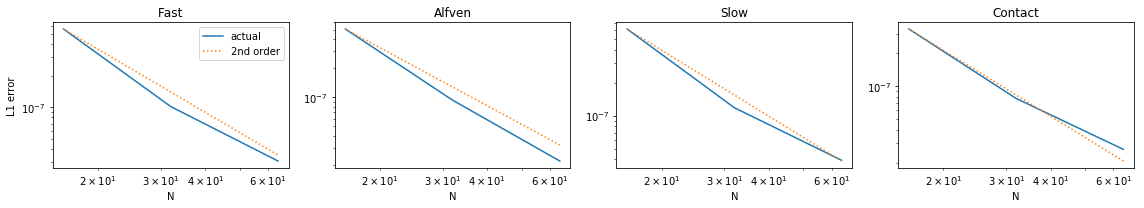

In [26]:
#plt.show()

In [27]:
fig.savefig('Linear_MHD_wave_convergence.png',dpi=150,bbox_inches='tight')